# Problem Set 1: "Building a Strategic Portfolio"

In [216]:
# import packages
import pandas as pd
import numpy as np
import yfinance
import matplotlib.pylab as plt
import scipy.stats
import statsmodels.api as sm
from datetime import date

In [217]:
#load data from yfinance

#yfinance.download(['AAPL', 'MSFT', 'TSLA', 'ORSTED.CO', 'V', '^GSPC'], interval='1mo')['Close'].dropna().to_csv('data.csv')

# load data from csv file

data = pd.read_csv('data.csv', index_col=['Date'], date_format=['Date'])

data.head()

,AAPL,MSFT,ORSTED.CO,TSLA,V,^GSPC
Date,,,,,,
2016-06-01,21.849644,45.602222,210.907013,14.152000,69.670090,2098.860107
2016-07-01,23.817486,50.512691,237.851868,15.652667,73.314697,2173.600098
2016-08-01,24.249449,51.207798,232.322479,14.134000,75.991798,2170.949951
2016-09-01,25.977863,51.652504,241.362579,13.602000,77.817398,2168.270020
2016-10-01,26.090454,53.732960,235.833191,13.182000,77.638626,2126.149902


In [218]:
#get log-return

ticker = ['AAPL', 'MSFT', 'TSLA', 'ORSTED.CO', 'V']

for i in range(len(ticker)):
    data.loc[:, "logreturn_" + ticker[i]] = np.log(data[ticker[i]]) - np.log(data[ticker[i]].shift())

data = data.dropna()

data.tail()

,AAPL,MSFT,ORSTED.CO,TSLA,V,^GSPC,logreturn_AAPL,logreturn_MSFT,logreturn_TSLA,logreturn_ORSTED.CO,logreturn_V
Date,,,,,,,,,,,
2025-01-01,235.432083,413.470367,278.100006,404.600006,340.660065,6040.529785,-0.059308,-0.015397,0.001880,-0.153380,0.078357
2025-02-01,241.258011,395.469543,315.200012,292.980011,361.500336,5954.500000,0.024444,-0.044512,-0.322795,0.125227,0.059378
2025-03-01,221.839096,374.702118,301.399994,259.160004,349.878906,5611.850098,-0.083915,-0.053942,-0.122659,-0.044769,-0.032676
2025-04-01,212.221710,394.535706,261.799988,282.160004,344.927155,5569.060059,-0.044321,0.051578,0.085029,-0.140857,-0.014254
2025-05-01,195.270004,450.179993,266.399994,339.339996,353.540009,5802.819824,-0.083248,0.131938,0.184528,0.017418,0.024663


# Jarque-Bera test for normality

In [219]:
JB = np.zeros((len(ticker)))

for i in range(len(ticker)):
    S = scipy.stats.skew(data["logreturn_" + ticker[i]])
    K = scipy.stats.kurtosis(data["logreturn_" + ticker[i]], fisher=False)
    N = data.shape[0]
    JB[i] = (N / 6) * (S**2 + 0.25 * (K - 3)**2)


JB

array([1.69238776, 0.3497448 , 1.65410303, 5.61225211, 1.29152881])

In [220]:
cdf = np.zeros((len(ticker)))

for i in range(len(ticker)):
    cdf[i] = scipy.stats.chi2.cdf(JB[i], 2)

cdf

array([0.57095518, 0.16043586, 0.56266313, 0.93956132, 0.47573836])

In [221]:
a = 0.05

p = np.zeros((len(ticker)))

for i in range(len(ticker)):
    p[i] = 1 - cdf[i]
    if p[i] > a:
        print(ticker[i] + ": probably normal distributed")
    else: 
        print(ticker[i] + ": not normal distributen")


p

AAPL: probably normal distributed
MSFT: probably normal distributed
TSLA: probably normal distributed
ORSTED.CO: probably normal distributed
V: probably normal distributed


array([0.42904482, 0.83956414, 0.43733687, 0.06043868, 0.52426164])

# Build the IOS

In [222]:
mu = np.zeros((len(ticker)))

for i in range(len(ticker)):
    mu[i] = np.mean(data["logreturn_" + ticker[i]])*12 # annualized return

Sigma = (np.cov(data[['logreturn_AAPL', 'logreturn_MSFT', 'logreturn_TSLA', 'logreturn_ORSTED.CO', 'logreturn_V']].T)*12).round(4) # annulized covariance matrix

print(mu)
print(Sigma)

[0.24562975 0.25678778 0.3563155  0.02619606 0.18215614]
[[0.0747 0.0314 0.0874 0.0223 0.0272]
 [0.0314 0.0382 0.0508 0.0142 0.0181]
 [0.0874 0.0508 0.3661 0.0238 0.0279]
 [0.0223 0.0142 0.0238 0.0924 0.0098]
 [0.0272 0.0181 0.0279 0.0098 0.0393]]


# Building the MV-Frontier

## 1. Unconstrained

In [223]:
#SINGLE OPTIMIZATIONS: Objective Function, Constraint Function, Starting Values, Bounds

def portfolio_variance(w):
        #input: w as numpy column vector
        #output: scalar
    return (w.T@Sigma@w).item() #objective function to be minimized


def eq_portfolio_return(w):
    #input: numpy portfolio column vector
    #note: mu_i is a global variable; needs to be known before calling this function
    #output: difference between w's expected return and the target return; scalar
    
    return (w.T@mu).item() - mu_i #constraint to meet target expected return mu_i


def eq_weight_sum(w): 
    #content: full investment constraint: 100% is invested in risky assets
    #input: numpy portfolio column vector
    #output: difference between sum of portfolio holdings and 100%=1. 
    
    return np.sum(w) - 1


# starting values
w0 = [0.2, 0.2, 0.2, 0.2, 0.2]

#no short-sale (bound) and minimum diversification bound
bounds = [(0, 0.5), (0, 0.5), (0, 0.5), (0, 0.5), (0, 0.5)]


constraints = [{'type': 'eq', 'fun': eq_portfolio_return},
               {'type': 'eq', 'fun': eq_weight_sum}
               ] #target return and full investment constraint

In [224]:
#Loop through y-axis (i.e. mu_i)

mu_min = 0.01
mu_max = 1
incr = 0.001

In [225]:
#number of evaluations
nr_evals = int( (mu_max - mu_min) / incr + 1)
nr_evals #number of portfolios on the MV-frontier

991

In [226]:
# MV-Frontier

w_MV = np.zeros((nr_evals, 5))
mu_MV = np.zeros((nr_evals,))
sigma_MV = np.zeros((nr_evals,))

mu_i = mu_min
for i in range(0,nr_evals):
    w_opt = scipy.optimize.minimize(portfolio_variance, w0, constraints=constraints)
    w_MV[i,:] = w_opt.x
    mu_MV[i] = (w_opt.x.T@mu).item() 
    sigma_MV[i] = (w_opt.x.T@Sigma@w_opt.x).item()**0.5
    
    mu_i = mu_i + incr

<>:12: SyntaxWarning: invalid escape sequence '\s'
<>:12: SyntaxWarning: invalid escape sequence '\s'
/var/folders/l7/q149vsq90bb6jd1b96qw2qyc0000gn/T/ipykernel_4433/2870952613.py:12: SyntaxWarning: invalid escape sequence '\s'
  plt.xlabel('$\sigma(r)$')


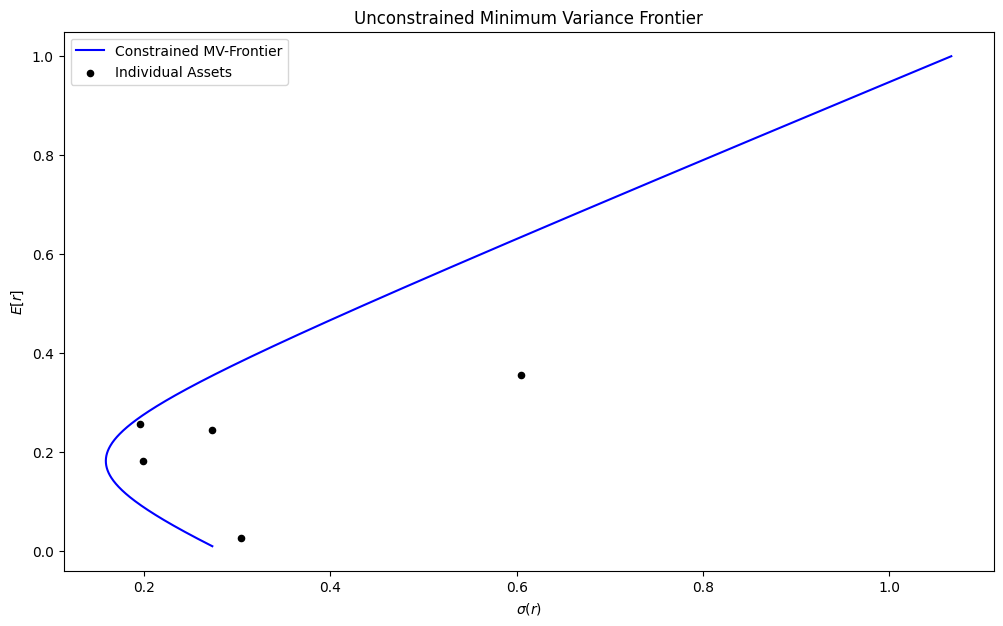

In [227]:
# Plot MV-Frontier

plt.figure(1, figsize=(12,7))

#show the MV-frontier that obeys constraints and bounds
plt.plot(sigma_MV, mu_MV, color='blue',label='Constrained MV-Frontier')

# add single assets investment opportunities
plt.scatter(np.diag(Sigma)**0.5, mu[:], s=20, color='black', label='Individual Assets')

#descrive axis
plt.xlabel('$\sigma(r)$')
plt.ylabel('$E[r]$')

plt.legend()

#add a title
plt.title('Unconstrained Minimum Variance Frontier')
plt.show()

## Constrained

In [228]:
#Loop through y-axis (i.e. mu_i)

mu_min = 0.01
mu_max = 1
incr = 0.001

In [229]:
#number of evaluations
nr_evals = int( (mu_max - mu_min) / incr + 1)
nr_evals #number of portfolios on the MV-frontier

991

In [230]:
# MV-Frontier

w_MV = np.zeros((nr_evals, 5))
mu_MV = np.zeros((nr_evals,))
sigma_MV = np.zeros((nr_evals,))

mu_i = mu_min
for i in range(0,nr_evals):
    w_opt = scipy.optimize.minimize(portfolio_variance, w0, bounds=bounds, constraints=constraints)
    w_MV[i,:] = w_opt.x
    mu_MV[i] = (w_opt.x.T@mu).item()  #MU: come back here.
    sigma_MV[i] = (w_opt.x.T@Sigma@w_opt.x).item()**0.5
    
    mu_i = mu_i + incr

<>:12: SyntaxWarning: invalid escape sequence '\s'
<>:12: SyntaxWarning: invalid escape sequence '\s'
/var/folders/l7/q149vsq90bb6jd1b96qw2qyc0000gn/T/ipykernel_4433/1086647150.py:12: SyntaxWarning: invalid escape sequence '\s'
  plt.xlabel('$\sigma(r)$')


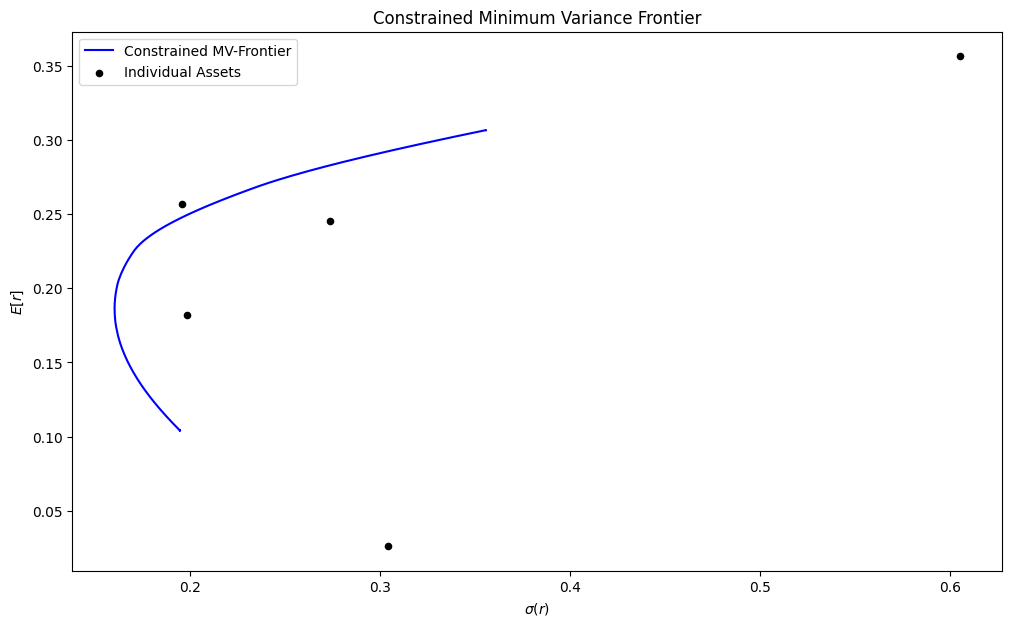

In [231]:
# Plot MV-Frontier

plt.figure(1, figsize=(12,7))

#show the MV-frontier that obeys constraints and bounds
plt.plot(sigma_MV, mu_MV, color='blue',label='Constrained MV-Frontier')

# add single assets investment opportunities
plt.scatter(np.diag(Sigma)**0.5, mu[:], s=20, color='black', label='Individual Assets')

#descrive axis
plt.xlabel('$\sigma(r)$')
plt.ylabel('$E[r]$')

plt.legend()

#add a title
plt.title('Constrained Minimum Variance Frontier')
plt.show()

# Tangency Portfolio

In [232]:
rf = 0.04146 # U.S. 1 Year Treasury

SR_MV = (mu_MV - rf) / sigma_MV

TP_index = np.argmax(SR_MV)

TP_index

222

In [233]:
w_TP = w_MV[TP_index]
w_TP

array([0.13550356, 0.5       , 0.02254912, 0.        , 0.34194732])

In [234]:
mu_TP = mu_MV[TP_index]
mu_TP

0.23199999997466042

In [235]:
sigma_TP = sigma_MV[TP_index]
sigma_TP

0.17543526791697156

In [236]:
SR_TP = (mu_TP - rf) / sigma_TP
SR_TP

1.0860986062667712

# Optimal Complete Portfolio

In [237]:
A = 8

y = (mu_TP - rf) / (A * (sigma_TP ** 2))

y

0.7738599393116258

In [238]:
mu_C = y*mu_TP+(1-y)*rf 

sigma_C = y*sigma_TP

utility_C = mu_C - 0.5*A*(sigma_C**2)

<>:25: SyntaxWarning: invalid escape sequence '\s'
<>:25: SyntaxWarning: invalid escape sequence '\s'
/var/folders/l7/q149vsq90bb6jd1b96qw2qyc0000gn/T/ipykernel_4433/328422057.py:25: SyntaxWarning: invalid escape sequence '\s'
  plt.xlabel('$\sigma(r)$')


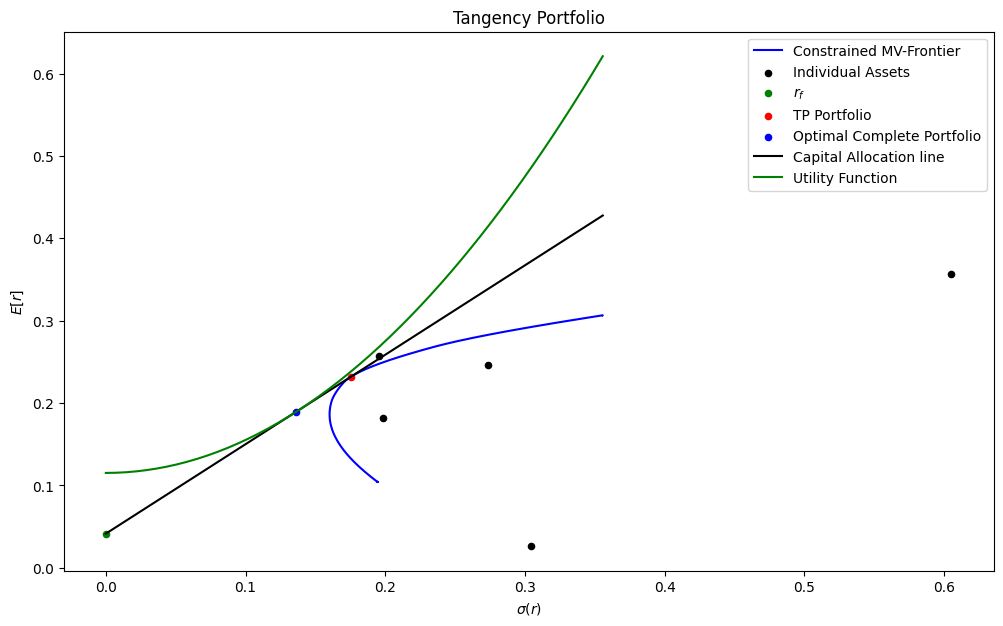

In [239]:
# Plot Tangency Portfolio

plt.figure(1, figsize=(12,7))

#show the MV-frontier that obeys constraints and bounds
plt.plot(sigma_MV, mu_MV, color='blue',label='Constrained MV-Frontier')

# add single assets investment opportunities and risk-free asset
plt.scatter(np.diag(Sigma)**0.5, mu, s=20, color='black', label='Individual Assets')
plt.scatter([0], [rf], s = 20, color='green', label='$r_f$')
plt.scatter(sigma_TP, mu_TP, s = 20, color='red', label='TP Portfolio')
plt.scatter(sigma_C, mu_C, s = 20, color='Blue', label='Optimal Complete Portfolio')

# add capital market line
x = np.linspace(0, np.max(sigma_MV))
y = rf + SR_TP * x
plt.plot(x, y, color='black', label='Capital Allocation line')

# add utility function
x = np.linspace(0, np.max(sigma_MV))
y = utility_C + 0.5*A*(x**2)
plt.plot(x, y, color='green', label='Utility Function')

#descrive axis
plt.xlabel('$\sigma(r)$')
plt.ylabel('$E[r]$')


plt.legend()

#add a title
plt.title('Tangency Portfolio')
plt.show()

# Decomposing expected portfolio performance (return and risk) into systematic ans idiosyncratic components

In [240]:
# calculate SP500 log-return
data['logreturn_^GSPC'] = np.log(data['^GSPC']) - np.log(data['^GSPC'].shift(1))

In [241]:
# drop nan
data = data.dropna()

In [242]:
# risk free return rate per month
rf_monthly = rf / 12

rf_monthly

0.0034549999999999997

In [243]:
# calculate OLS Model for each stock

betas = []
alphas = []

for i in range(len(ticker)):
    y = data["logreturn_" + ticker[i]] - rf_monthly # monthly stock excess reuturn
    X = data['logreturn_^GSPC'] - rf_monthly # monthly market excess return
    X = sm.add_constant(X)
    model = sm.OLS(y, X).fit()

    betas.append(model.params.iloc[1])
    alphas.append(model.params.iloc[0]* 12) #annualized alpha

In [244]:
# Portfolio decomposition
portfolio_beta = np.sum(np.array(betas) * w_TP)
portfolio_alpha = np.sum(np.array(alphas) * w_TP)
systematic_var = portfolio_beta**2 * np.var(data['logreturn_^GSPC']) * 12

idiosyncratic_var = sigma_TP - systematic_var

print ( f" Portfolio Beta : { portfolio_beta :.4f}")
print ( f" Portfolio Alpha : { portfolio_alpha :.4f}")
print ( f" Systematic Variance : { systematic_var :.6f}")
print ( f" Idiosyncratic Variance : { idiosyncratic_var :.6f}")

 Portfolio Beta : 0.9540
 Portfolio Alpha : 0.1169
 Systematic Variance : 0.022175
 Idiosyncratic Variance : 0.153261


# Expected vs. Realized Performance

In [245]:
# build train and test data set
train_data = data.iloc[:int(len(data) * 0.7)][['logreturn_AAPL', 'logreturn_MSFT', 'logreturn_TSLA', 'logreturn_ORSTED.CO', 'logreturn_V']]
test_data = data.iloc[-int(len(data) * 0.3):][['logreturn_AAPL', 'logreturn_MSFT', 'logreturn_TSLA', 'logreturn_ORSTED.CO', 'logreturn_V']]

In [246]:
# calculate expected performance
mean_train_data = train_data.mean() * 12
sigma_train_data = train_data.cov() * 12

exp_return = np.sum(mean_train_data * w_TP)
exp_vol = np.sqrt(w_TP @ sigma_train_data @ w_TP)

In [ ]:
# calculate realized performance

realized_returns = np.sum(test_data * w_TP)
realized_return = realized_returns.mean() * 12
realized_vol = realized_returns.std() * np.sqrt(12)

In [249]:
print(f" Expected Return : { exp_return :.4f} , Realized Return :{ realized_return :.4f}")

print(f" Expected Volatility : { exp_vol :.4f} , Realized Volatility :{ realized_vol :.4f}")

 Expected Return : 0.2186 , Realized Return :1.3833
 Expected Volatility : 0.1857 , Realized Volatility :0.5148
